**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson
Remember: data is already preprocessed.

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): 
    return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid

X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(predictions, actuals): 
    return math.sqrt(((predictions - actuals)**2).mean())

def print_score(m):
    print('RMSE for training:   ', rmse(m.predict(X_train), y_train))
    print('RMSE for validation: ', rmse(m.predict(X_valid), y_valid))
    print('R^2 for training:    ', m.score(X_train, y_train))
    print('R^2 for validation:  ', m.score(X_valid, y_valid))
    if hasattr(m, 'oob_score_'): 
        print('OoB error:           ', m.oob_score_)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

We choose a number high enough to get the same results if we execute this again. 50000 is a good number to start with.

In [7]:
set_rf_samples??

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE for training:    0.20591641253881404
RMSE for validation:  0.25250584488989847
R^2 for training:     0.9115949046544434
R^2 for validation:   0.8780198740080553
OoB error:            0.8944813743441379


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the **standard deviation** of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [10]:
%time preds = np.stack([tree.predict(X_valid) for tree in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.68 s


(10.378191578980424, 0.12654774153256645)

When we use python to loop through trees like this, we're calculating each in series (Python runs everything simple, as list comprehensions, in only one core), which is slow! We can use **parallel processing** to speed things up. For decision trees we have the `parallel_trees` function in fastai that will accomplish that. (Note: I use a custom parallel_trees function, since the fastai's one did not work):

In [11]:
def get_preds(tree): 
    return tree.predict(X_valid)

def parallel_trees(m, fn, n_jobs=8):
    return list(ThreadPoolExecutor(n_jobs).map(fn, m.estimators_))

%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.61 s


(10.378191578980424, 0.12654774153256645)

We can see that different trees are giving different estimates. In order to see how prediction confidence varies, we can add the mean and the std dev of these predictions into our dataset.

In [12]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0) # std dev of the predictions accross the X axis
x['pred'] = np.mean(preds, axis=0) # mean of the predictions accross the X axis

Enclosure is one of the variables (predictors) we have. Let's plot an histogram to see the distribution of samples within each category:

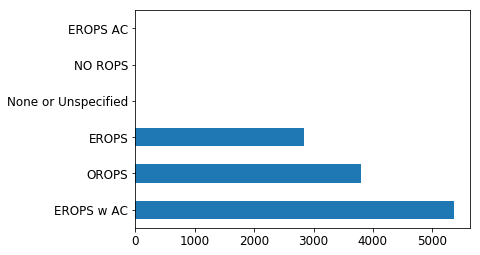

In [13]:
x.Enclosure.value_counts().plot.barh();

The important ones are the last three, since the others basically don't exist. We'll try to explain these EROPS and OROPS later.

Now we'll group our dataframe by this Enclosure variable, and calculate the mean inside each enclosure for the others fields:

In [14]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.888158,9.866248,0.285666
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.614880,10.545729,0.269122
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.788210,9.774668,0.228615


Let's plot it! in a first graph the actual SalePrice mean is drawn. In a second one, the predicted sale price mean, with the confidence interval.

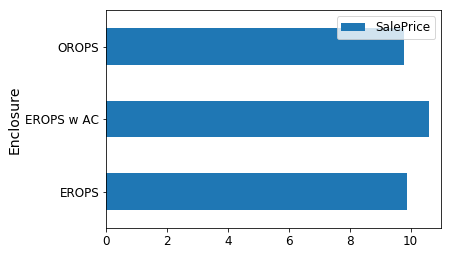

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

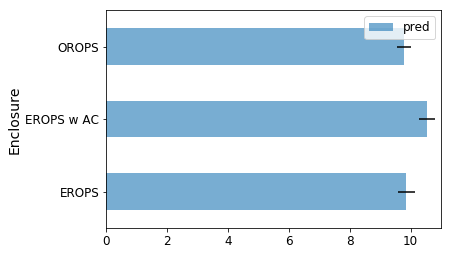

In [16]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

We do the same for ProductSize!

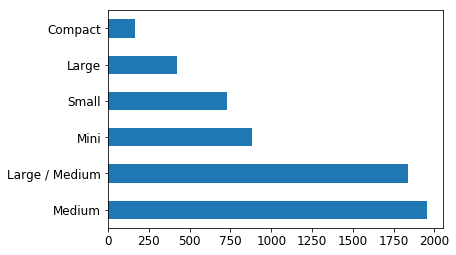

In [17]:
raw_valid.ProductSize.value_counts().plot.barh();

In [18]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.670200,9.717481,0.312491
Large,10.491001,10.372024,0.369926
Large / Medium,10.698794,10.641351,0.294775
Medium,10.704027,10.638704,0.293529
Mini,9.619849,9.625539,0.262510
Small,10.376032,10.304524,0.308592


In [19]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.035666
Compact           0.032158
Small             0.029947
Large / Medium    0.027701
Medium            0.027591
Mini              0.027272
dtype: float64

For the compact and large sizes we have a higher ratio between standard deviation and mean of the predictions. In the graph we see that we have less samples of those groups, so these samples are more rare and more difficult to fit in the trees. So this way we could see that our confidence to predict sales of specific product sizes is lower.

This could be done to the most important features, which we're seeing now...

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*. For RF we have the fastai's `rf_feat_importance` function, that measures that with a number:

In [20]:
fi = rf_feat_importance(m, df_trn)
fi[:10] # Top 10

,cols,imp
6,YearMade,0.163888
38,Coupler_System,0.104837
14,ProductSize,0.096097
15,fiProductClassDesc,0.066998
40,Hydraulics_Flow,0.058807
11,fiSecondaryDesc,0.054735
3,ModelID,0.050818
64,saleElapsed,0.048638
20,Enclosure,0.039682
39,Grouser_Tracks,0.036473


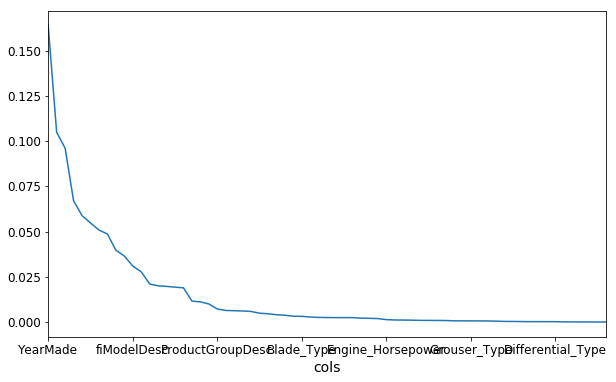

In [21]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

This give us a great and useful knowledge about the domain of the problem! Let's paint it with other approach:

In [22]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

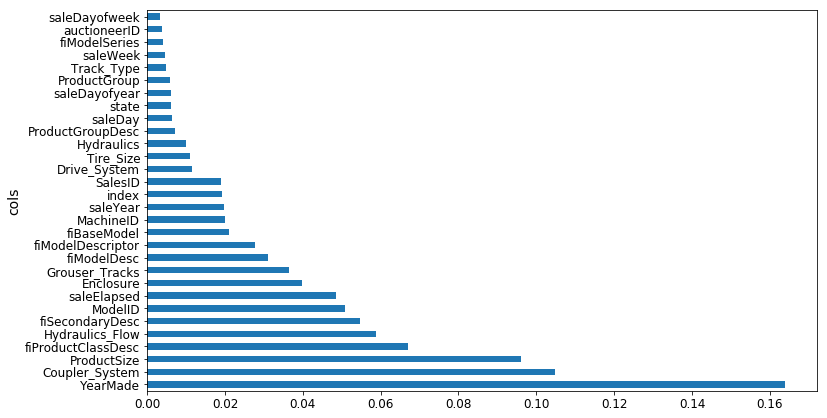

In [23]:
plot_fi(fi[:30]);

Enclosure, that variable that we don't even know what it is, appears in the 7th place. So definitely we'll want to to know more about it. And the same goes for the rest of the top N. This will give us domain knowledge.

One interesting thing to do at this point is to throw away some variables, and test what happens with RMSE or R^2. We take now only the N variables that make an appreciable effect... (0.005 as the threshold because we see in the above graph that's the value, more or less, when the tendency flattens; if the score is worse, we can decrease this threshold value until it does not affect the score).

In [24]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

25

We create a new dataframe, new subsets and a new model with them:

In [25]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE for training:    0.20734004336407447
RMSE for validation:  0.2512328732279634
R^2 for training:     0.9103682779932779
R^2 for validation:   0.879246664143564
OoB error:            0.8938899505358177


If the result is better we keep this model; even if the result is the same (the model is simplier!).

We redraw the feature importance graph:

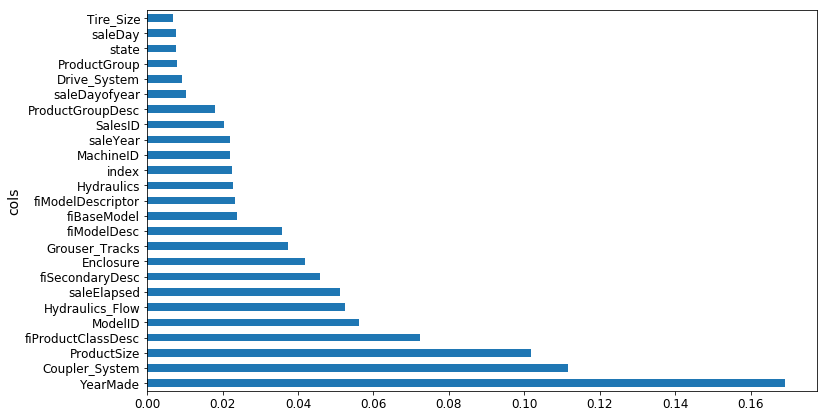

In [27]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

This graph is now clearer (some variables have more importance, others like Coupler_System has less) without the discarded ones. For sure we reduced redundancy. Now we have 4 features over the rest.

We can do more with these features. Maybe a particular analysis like we did before for ProductSize or Enclosure. Or we can search to high valued categorical features (maybe we see a pattern in the values and can create new columns).

## One-hot encoding

We remember that if we have a categorical feature, with only a few values (low cardinality), and the order or the number of samples matters, decision trees maybe will need one more branch to model the data if the main category was by the middle. More branching will do the tree less rich or effective. Moreover, in terms of interpretability we don't see the influence of each category in the prediction (the category importance).

There's something we can do to improve our model: create a column for each category...

The proc_df's optional `max_n_cat` argument will turn some categorical variables into new columns. It will only happen to columns whose number of categories is no bigger than the value of the `max_n_cat` argument.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

NOTE: if we did some categorical reorder (UsageBand) and we don't want One hot encoding to throw away that, we should convert that column to numerical (overwrite it with the ordered cat codes).

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [28]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE for training:    0.20732144154838847
RMSE for validation:  0.2548852132954669
R^2 for training:     0.910384360154279
R^2 for validation:   0.8757101998959816
OoB error:            0.8926110536437907


In this case the score is a bit worse (almost nothing) but we have achieved something really great:

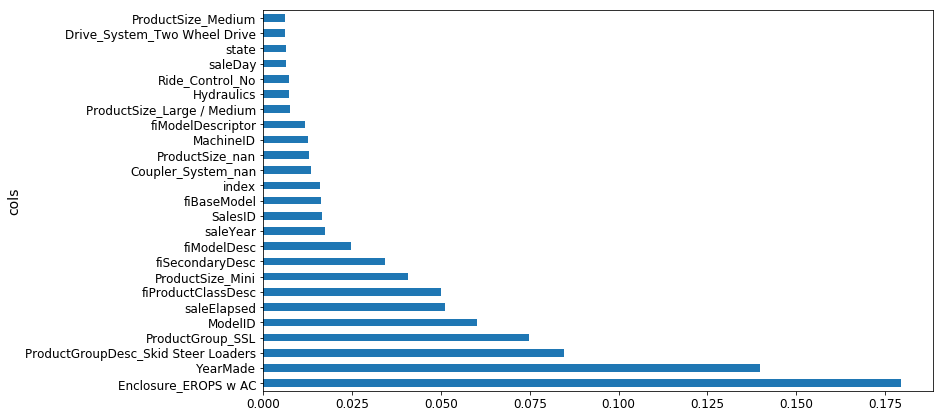

In [29]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

Sure you can't deny the importance of the Enclosure variable now! We need to know what EROPS w AC is right now :)

We could increase max_n_cat's value to test the result too. 

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundant features.

First we'll draw a dendogram! Jeremy uses Spearman’s correlation because Random Forests don't care about linearity, they just care about ordering. Spearman’s calculates R between independent variables (correlation is almost exactly the same as the R², but between two variables rather than between a variable and its prediction). The problem with a normal correlation is that it only works well when the relation (x1 vs x2) is linear, and it's not the case.

In [30]:
from scipy.cluster import hierarchy as hc

In [31]:
?hc.linkage

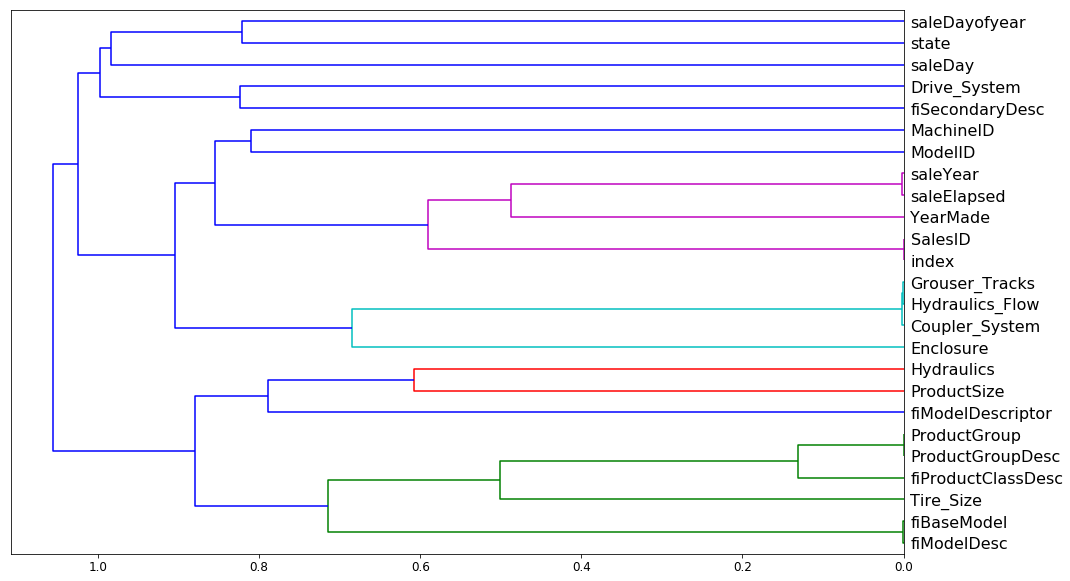

In [32]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4) # correlation matrix
corr_condensed = hc.distance.squareform(1-corr)                # distances matrix
z = hc.linkage(corr_condensed, method='average')               # hierarchical/agglomerative clustering

fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

What we see in the dendogram is that there are some features very similar (closer to the right):
 * saleYear - saleElapsed
 * index - SalesID
 * Hydraulics_Flow - Grouser_Tracks - Coupler_System (so the coupler system maybe depends on the model)
 * ProductGroupDesc - ProductGroup
 * fiBaseModel - fiModelDesc

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [33]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline OoB score:

In [34]:
get_oob(df_keep)

0.8898188232155191

Now we try removing each variable one at a time.

In [35]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8899340331312392
saleElapsed 0.886597328319098
fiModelDesc 0.8895167490460334
fiBaseModel 0.889452606968955
Grouser_Tracks 0.8901313498709833
Coupler_System 0.8905944988254911


It looks like we can try one from each group for removal (none of the above produces a sensible deterioration of the OoB score). Let's see what that does.

In [36]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8892649405434464

It's worse, but almost the same. Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [37]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [38]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [39]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [40]:
reset_rf_samples()

In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE for training:    0.12383661869063045
RMSE for validation:  0.23795551248250044
R^2 for training:     0.9680262525238109
R^2 for validation:   0.8916727428308675
OoB error:            0.9087831927523755


# Partial dependence

One more technique we can apply is partial dependence. Our purpose here is to find how much is the dependence between the target variable and each of the independent variables.

In [42]:
from pdpbox import pdp
from plotnine import *

In [43]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [44]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

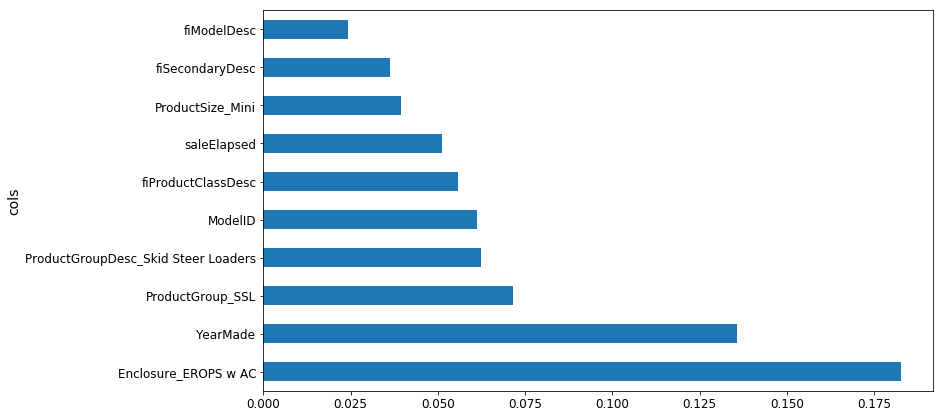

In [45]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

Let's explore the relationship between YearMade and saleElapsed with a scatterplot:

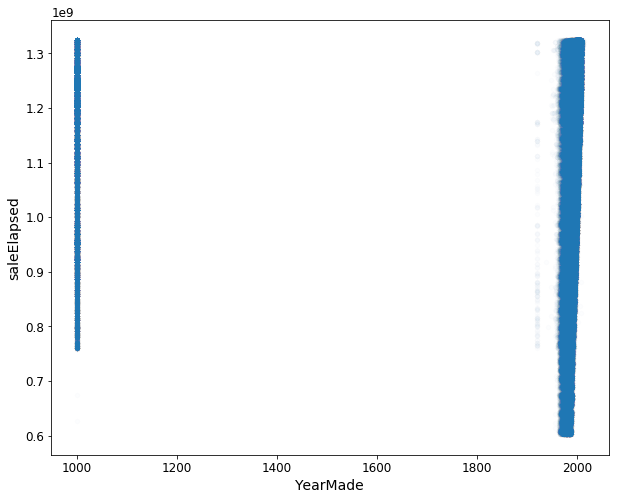

In [46]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

So we realize there are a lot of samples for which we don't have the YearMade value. Let's get rid of them for this analysis.

We'll get a sample of the dataframe, because to plot things there is no need of drawing all points (it's a mess, and requires more resources).

In [47]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 2000) # 500 was too low!

We wanna draw SalePrice vs YearMade. We'll use ggplot (originally an R library also known as grammar for graphics) this time. The parameters are the dataframe and the colums (through aes - aka aesthetic - function). Then you have the option in ggplot to use the `+` to add chart elements; in this case we add a smoother (better than a scatterplot; basically creates a little linear regression for every little subset of the graph). We can see a nice smooth curve. It's a great way to look at univariate relationships. By adding se=True (standard error), it also draws the confidence interval of this smoother. The loess method stands for locally weighted regression which is this idea of doing lots of little mini regressions.

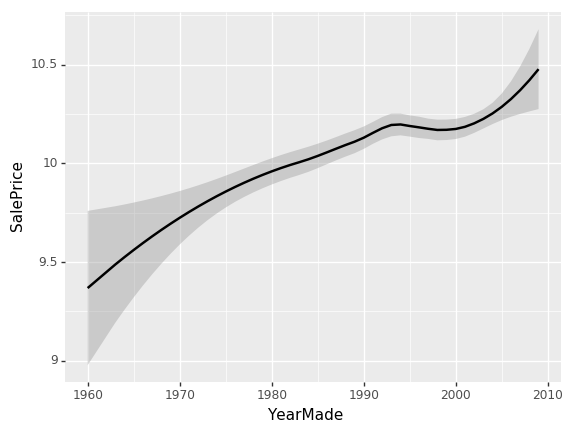

<ggplot: (159766501931)>

In [48]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

What we'd really wanna do is to compare SalePrice with YearMade with all the others variables being equal, to get some light over the decrease in price in the late 90s (we expected to have a more or less linear relationship. We'll do a **partial dependence plot** using pdp library...

In [49]:
x = get_sample(X_train[X_train.YearMade>1930], 2000)

In [50]:
def plot_pdp(feat_name, clusters=None):
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2532ad9c198>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2532b4ff4e0>})

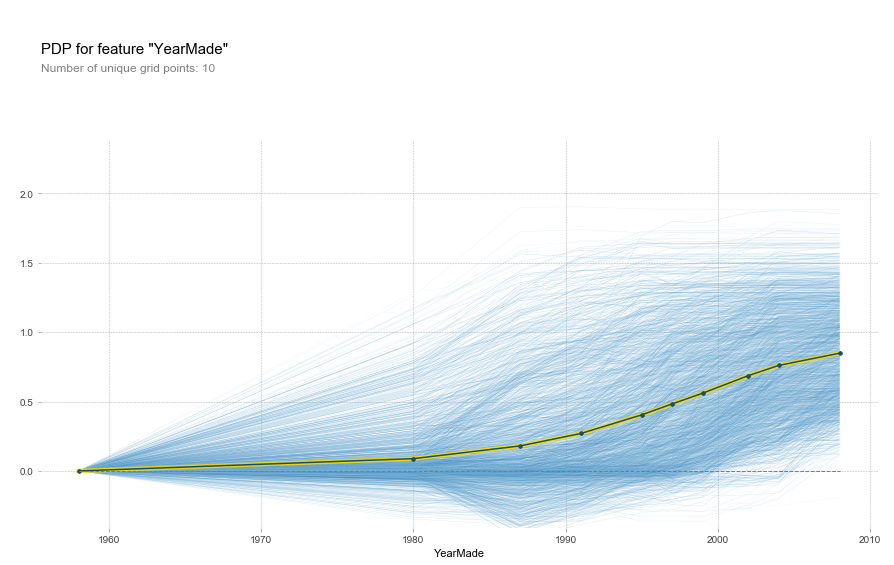

In [51]:
plot_pdp('YearMade')

What this really does: it takes the dataset (or the sample), fixes the value for the YearMade column (for example 1960), and applies RF to predict the SalePrice. For the fixed year it'll give us the predictions for the prices from all the sales as if they had occured in that year. The plot is the result of doing that for every year. The yellow line is the average. The starting point is the same for all; it draws the relative evolution for each sample through the years. Lines below 0 are probably from the older models, showing their devaluation.

So this is a great way to know the truth about the dependence of the target variable with other (without the influence of the rest). With the above plot we could see that the price reduction in the late 90s was not because of the year made (makes sense). This could be used to get more knowledge of the data and the relationships between the variables. Very useful in real life, not so much in Kaggle competitions.

Another thing we can do with pdp is clustering of the patterns for the blue lines:

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25334e138d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25333a1c898>})

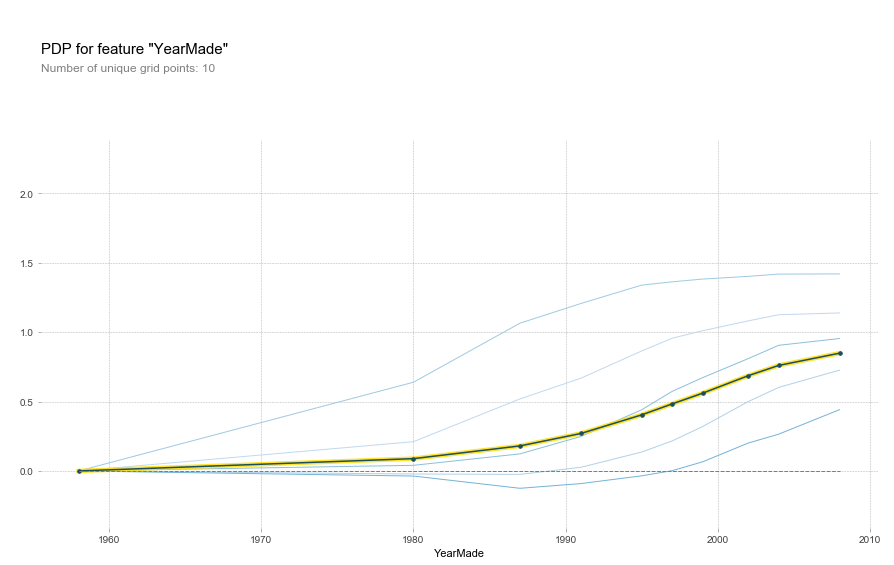

In [52]:
plot_pdp('YearMade', clusters=5)

We can also use pdp to see how 2 combined variables have effect on the target variable...

In [53]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
#pdp.pdp_interact_plot(p, feats, 'contour') # does not work even with matplotlib 2

![pdp_contour](images/pdp_contour.png)

If we do the same with a variable for which we applied one hot encoding, we pass the subcolumns as an array:

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25334e1b780>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x25334d2dcf8>})

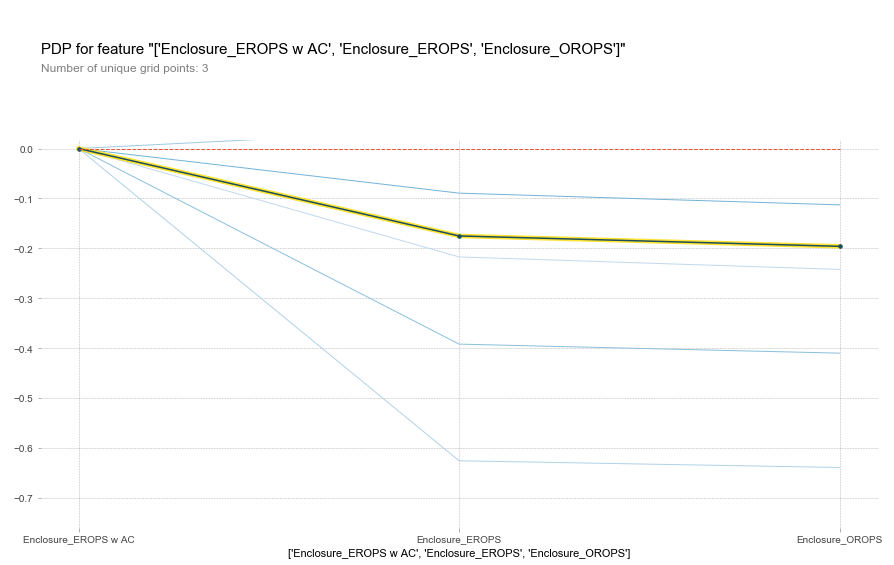

In [54]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5)

We can see that EROPS w AC is more expensive (in average). A quick search in google gives us the reason why: AC means Air Conditioned. E is for Enclosed, and O for Open. It's related to the cabin! so makes sense :)

We adjust the lost YearMade values to 1950, and create a new column for SaleYear minus YearMade. And retry the model...

In [55]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

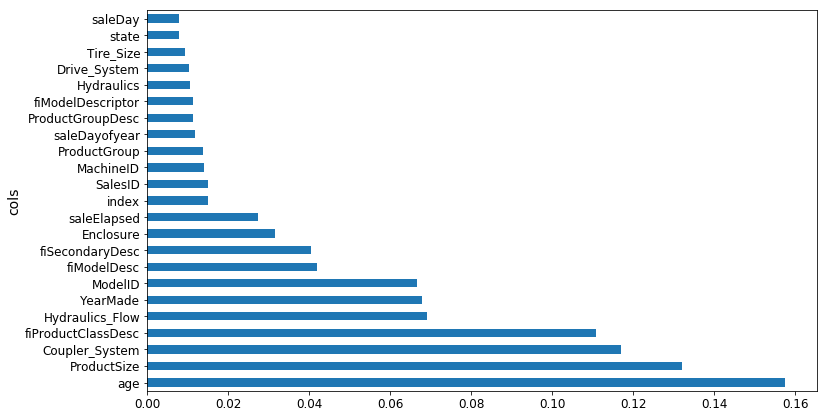

In [56]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

Surprise! the new column is now the most important one :D But have in mind that RF detect interactions. This new column maybe won't improve our results (that's what we'll get exactly; as seen later).

# Tree interpreter

This is another tool for model interpretability. As partial dependence, this is very useful for real life projects. It helps us to interpret individual predictions.

In [57]:
from treeinterpreter import treeinterpreter as ti

In [58]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

The idea is that we choose a row:

In [59]:
row = X_valid.values[None,0]
row

array([[      2004,          0,          0,          2,          0,         41,       3542, 1313712000,
                 6,        747,          0,     310084,     395688,    6276518,          2,          0,
                 0,          1,         19,         28,        231,          1,          7]], dtype=int64)

And using `predict` we get the prediction of SalePrice for that row, the average of SalePrice accross the whole dataset (when we drew the single tree it was the value in the root), and the *contributions* (how each of the predictors affect the prediction).

In [60]:
prediction, bias, contributions = ti.predict(m, row)

In [61]:
prediction[0], bias[0]

(array([10.38393]), 10.100924305039001)

In [62]:
idxs = np.argsort(contributions[0])

In [63]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('fiProductClassDesc',
  'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
  -0.18827614944955054),
 ('ProductGroup', 'BL', -0.049453008306671584),
 ('Hydraulics', nan, -0.04640734864283127),
 ('ProductSize', nan, -0.0369315391945487),
 ('ProductGroupDesc', 'Backhoe Loaders', -0.03225959266998313),
 ('Enclosure', 'OROPS', -0.024071328194336994),
 ('Tire_Size', nan, -0.011717004270759501),
 ('fiModelDescriptor', nan, -0.010974721413171995),
 ('state', 'Nevada', -0.0035726003120861716),
 ('saleDayofyear', 231, -0.0013961222531011508),
 ('saleDay', 19, -0.0006930187477566907),
 ('index', 395688, 0.002396852773809144),
 ('SalesID', 6276518, 0.011230892368463552),
 ('fiModelDesc', '420D', 0.020246317740477294),
 ('fiSecondaryDesc', 'D', 0.03478396105188049),
 ('Hydraulics_Flow', nan, 0.04034372130260348),
 ('MachineID', 310084, 0.0447902727067004),
 ('saleElapsed', 1313712000, 0.056974325360536995),
 ('Coupler_System', nan, 0.06993823327748779),
 ('ModelID', 3542, 0.07629107517511

We could use a waterfall plot to show this accross the decision tree, like the one built in Excel. Check this from a student of the course: [waterfallcharts](https://github.com/chrispaulca/waterfall)

In [64]:
contributions[0].sum()

0.2830049645451325

This technique is really interesting for interpretability of the predictions!

# Extrapolation

When we have an OoB score that isn't worse than the R^2 score, is a hint to think we can improve our model a little, handling our time component a little bit better :)

When we use a dataset with sale prices accross many years and we have to predict the price for next week, it would be great to extrapolate the increment in prices over the time to the future, but we can't do that in RF. Best we can do is stop using time variables for that, when we possibly could use something better, like for example an economic indicator, the price of prime materials, etc. This is the same for other cases.

Other thing we can do is check what are the differences between our training and our validation sets. That way we can know what features have a strong temporal component, and maybe they are irrelevant for the time we have to do the predictions.

We are adding a new column, which says if the sample is in the validation test. And then we'll train a RF model with the new variable as the target one, so we're predicting if the sample is in the validation set:

In [65]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [66]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999700841383609

We are able to predict if a sample is in the validation test (it's a valid proof to know that a test set is not random).

We get the most important variables for the prediction, and what we'll get in fact are the most time dependent ones!

In [67]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
7,saleElapsed,0.718851
12,index,0.109379
13,SalesID,0.090913
20,saleDayofyear,0.048124
11,MachineID,0.025707
22,age,0.002694
18,saleDay,0.002395
8,Enclosure,0.000635
19,state,0.000359
16,Hydraulics,0.000334


Nos quedamos con las top, y comparamos sus estadísticos para ambos subconjuntos de muestras:

In [68]:
feats=['saleElapsed', 'SalesID', 'index', 'saleDayofyear', 'MachineID']

In [69]:
(X_train[feats]/1000).describe()

,saleElapsed,SalesID,index,saleDayofyear,MachineID
count,3.891250e+05,389125.000000,389125.000000,389125.000000,389125.000000
mean,1.084389e+06,1829.352227,196.482649,0.176220,1205.539980
std,1.799262e+05,688.683996,112.776752,0.102636,426.910622
min,6.009984e+05,1139.246000,0.000000,0.002000,0.000000
25%,9.666432e+05,1416.619000,99.061000,0.083000,1089.252000
50%,1.134605e+06,1634.496000,196.493000,0.165000,1274.977000
75%,1.234138e+06,2220.152000,293.904000,0.268000,1458.609000
max,1.313712e+06,6333.281000,401.109000,0.365000,2386.738000


In [70]:
(X_valid[feats]/1000).describe()

,saleElapsed,SalesID,index,saleDayofyear,MachineID
count,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000
mean,1.319832e+06,4849.833320,332.843470,0.301833,1618.783561
std,3.448105e+03,1841.642914,133.201206,0.039909,652.031790
min,1.313712e+06,1140.212000,0.287000,0.231000,0.830000
25%,1.316736e+06,4277.997750,381.089750,0.266000,1053.993250
50%,1.319674e+06,6258.986500,392.901500,0.300000,1847.404000
75%,1.323302e+06,6285.309250,397.000250,0.342000,2270.156000
max,1.325203e+06,6333.342000,401.124000,0.364000,2486.330000


If we can confirm their values are very different, we can drop them (mean is almost enough). In this case we are not dropping saleDayofyear.

In [71]:
feats=['saleElapsed', 'SalesID', 'MachineID', 'saleDayofyear', 'index']

In [72]:
x.drop(feats, axis=1, inplace=True)

In [73]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9749330009348707

In [74]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
17,age,0.245673
0,YearMade,0.185999
14,saleDay,0.122613
15,state,0.104399
6,ModelID,0.080580
8,fiModelDesc,0.073195
3,fiProductClassDesc,0.046250
5,fiSecondaryDesc,0.034895
7,Enclosure,0.020002
12,Hydraulics,0.016009


Let's train again with all...

In [ ]:
set_rf_samples(50000)

In [75]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'index', 'age', 'YearMade', 'saleDayofyear']

As a basis...

In [76]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE for training:    0.20756946640407894
RMSE for validation:  0.2561894967890072
R^2 for training:     0.9101698121429271
R^2 for validation:   0.8744349285672638
OoB error:            0.8935895883074935


We train the model again without one of the above features each time to get the scores:

In [77]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
RMSE for training:    0.20796682355776983
RMSE for validation:  0.2567091197325327
R^2 for training:     0.9098255530943495
R^2 for validation:   0.8739250508261447
OoB error:            0.8932466112943684
saleElapsed
RMSE for training:    0.21353477096387252
RMSE for validation:  0.26394171039321357
R^2 for training:     0.9049323897200311
R^2 for validation:   0.8667208359439201
OoB error:            0.8876857326674106
MachineID
RMSE for training:    0.2061912279245256
RMSE for validation:  0.25489033394477245
R^2 for training:     0.9113587768767223
R^2 for validation:   0.8757052058764112
OoB error:            0.8954334631290364
index
RMSE for training:    0.2082917121219464
RMSE for validation:  0.2562834746086682
R^2 for training:     0.9095435895591438
R^2 for validation:   0.8743427897704701
OoB error:            0.8929027154271362
age
RMSE for training:    0.20890289534016296
RMSE for validation:  0.254150745104191
R^2 for training:     0.9090119644593102
R^2 for valid

So we'll remove the features that increased the score when we dropped them alone!

In [78]:
reset_rf_samples()

In [79]:
df_subs = df_keep.drop(['age', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE for training:    0.1276298712129717
RMSE for validation:  0.2363417729818043
R^2 for training:     0.9660374702283797
R^2 for validation:   0.8931370435494759
OoB error:            0.9076521121382692


Yep! it worked! But OoB remains greater than R^2 :( Jeremy achieved a major improvement and OoB was less than R^2. Point to check!

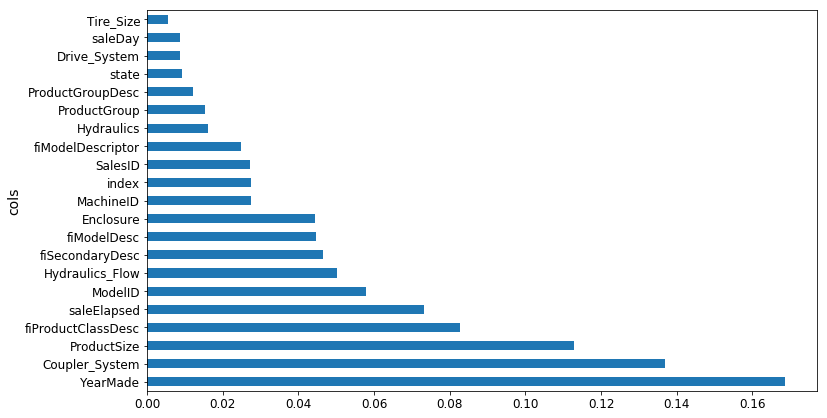

In [80]:
plot_fi(rf_feat_importance(m, X_train));

In [81]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [82]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 1min 45s
RMSE for training:    0.07511780847568444
RMSE for validation:  0.238018180589918
R^2 for training:     0.9882352910275061
R^2 for validation:   0.8916156770537309
OoB error:            0.9139368642876231
